Ejercicio simple para mostrar la prediccion que se puede realizar para Time Series.  
Se uso la data de consumo de energia (data horaria) de PJM (empresa de energia en USA) para la seccion Este.

In [76]:
import pandas as  pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error

palet_color = sns.color_palette()
plt.style.use('fivethirtyeight')

In [32]:
df = pd.read_csv('PJME_hourly.csv')
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

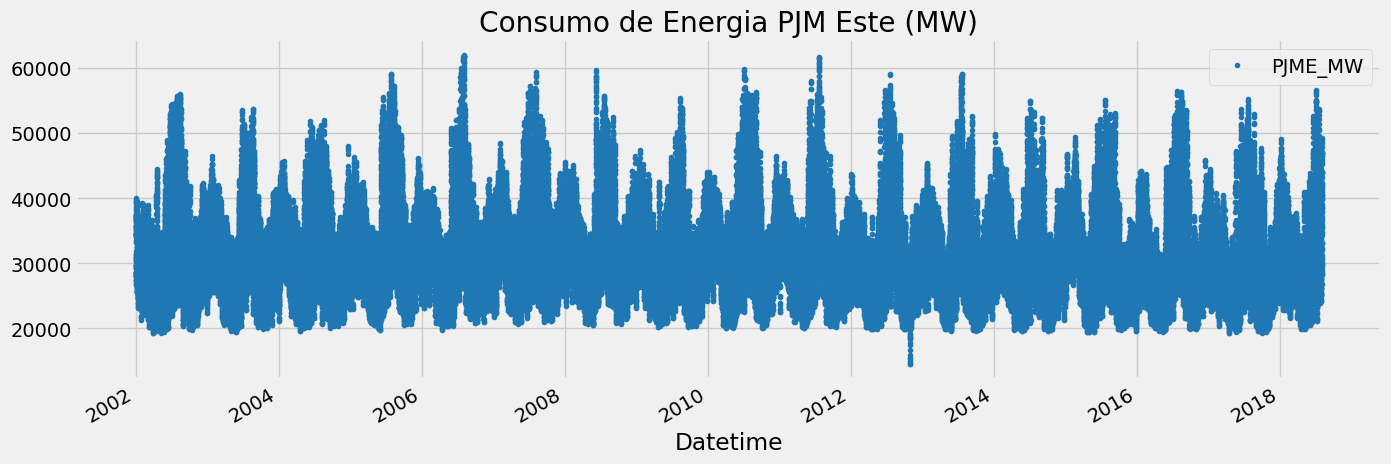

In [29]:
df.plot(style='.',
        figsize=(15, 5),
        color=palet_color[0],
        title='Consumo de Energia PJM Este (MW)',
        fontsize=14)
plt.show()

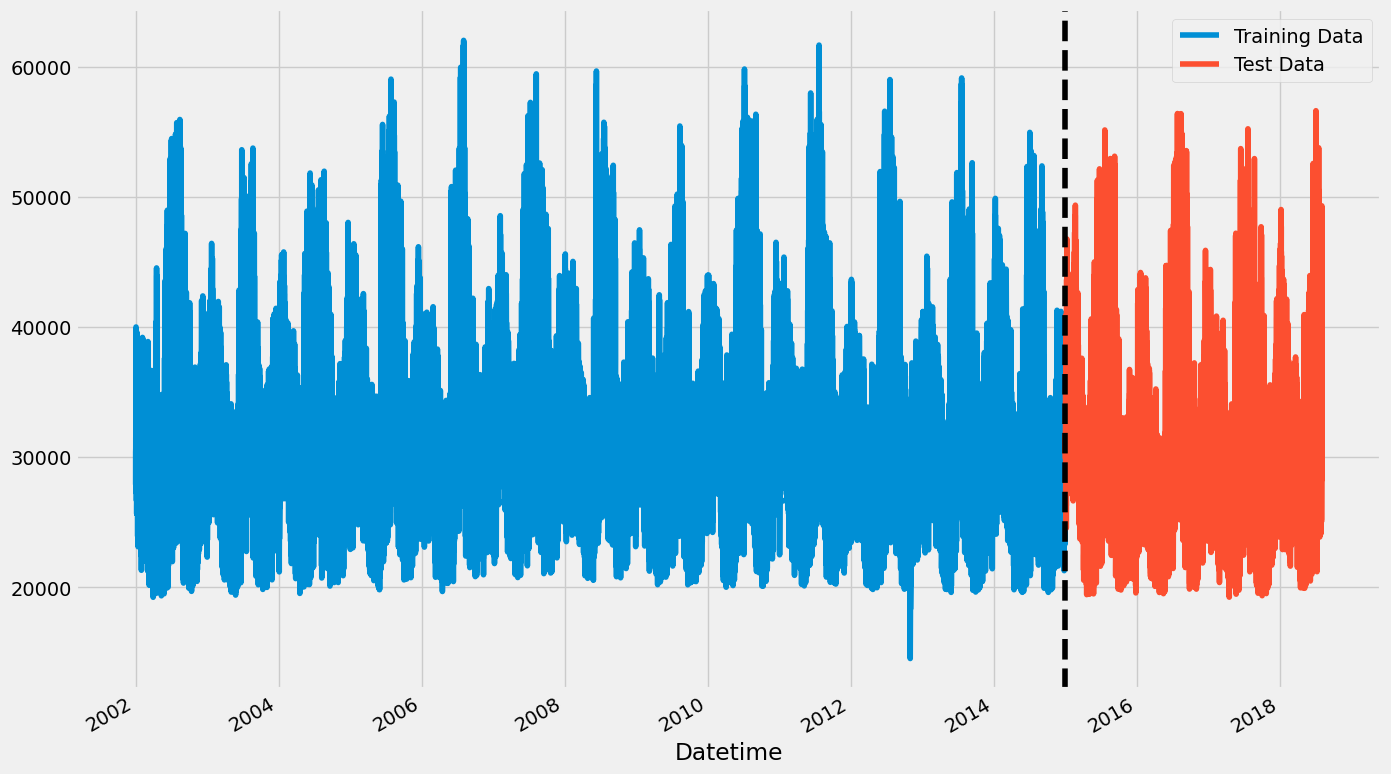

In [30]:
train_data = df.loc[df.index < '2015-01-01']
test_data = df.loc[df.index >= '2015-01-01']

fig, ax = plt.subplots(figsize=(15, 10))
train_data.plot(ax=ax, label='Training Data')
test_data.plot(ax=ax, label='Test Data')
ax.axvline('2015-01-01', color='black', linestyle='--')
plt.legend(['Training Data', 'Test Data'])
plt.show()

<Axes: title={'center': 'Una semana de data'}, xlabel='Datetime'>

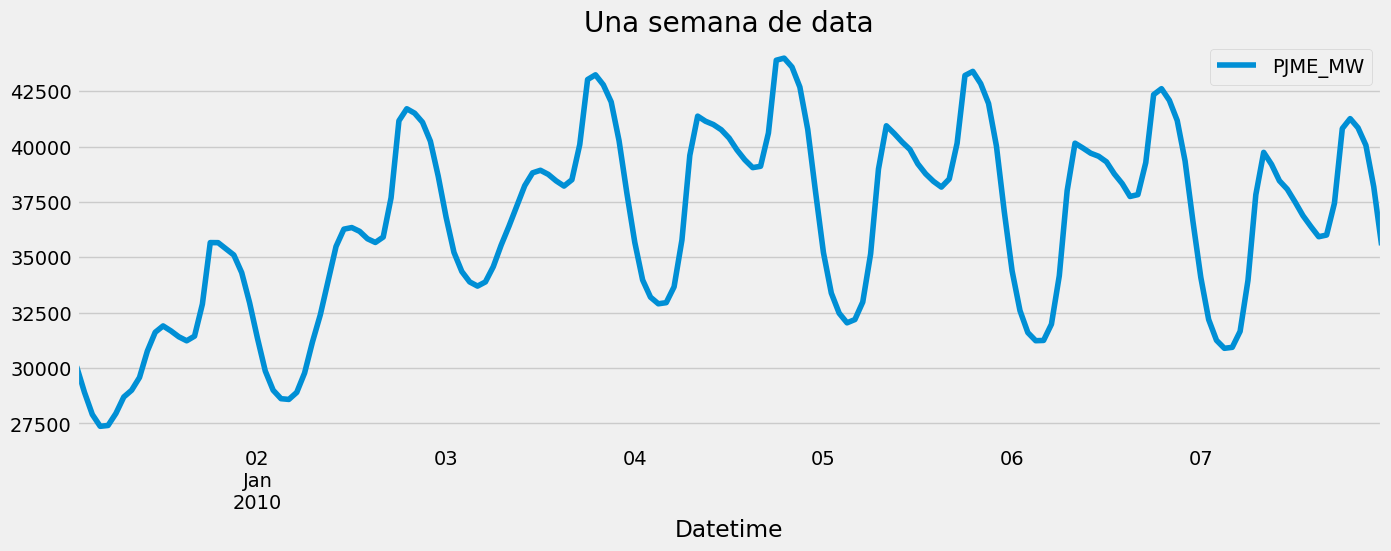

In [37]:
#  Visualizando una semana de data

df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-08')].sort_index().plot(
    figsize=(15, 5),
    title='Una semana de data')


In [38]:
# Featrue Engineering
def creacion_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    return df

In [40]:
df = creacion_features(df)
df

,PJME_MW,year,month,dayofyear,hour,dayofweek,quarter
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,2002,12,365,1,1,4
2002-12-31 02:00:00,25147.0,2002,12,365,2,1,4
2002-12-31 03:00:00,24574.0,2002,12,365,3,1,4
2002-12-31 04:00:00,24393.0,2002,12,365,4,1,4
2002-12-31 05:00:00,24860.0,2002,12,365,5,1,4
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,2018,1,1,20,0,1
2018-01-01 21:00:00,43751.0,2018,1,1,21,0,1
2018-01-01 22:00:00,42402.0,2018,1,1,22,0,1


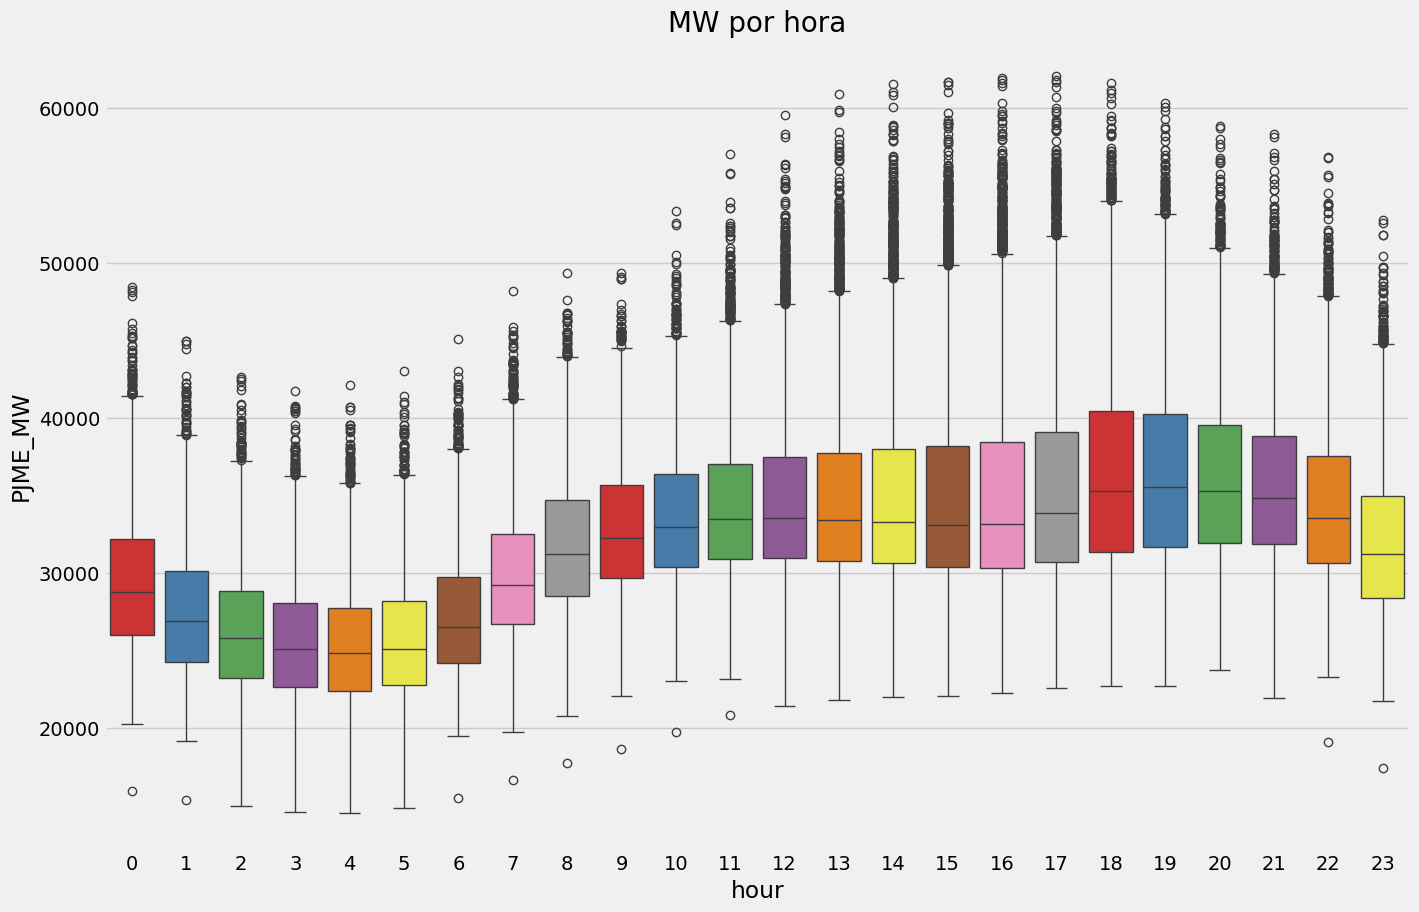

In [50]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(data=df, x='hour', y='PJME_MW', hue='hour',legend=False,palette='Set1')
ax.set_title("MW por hora", fontsize=20)
plt.show()

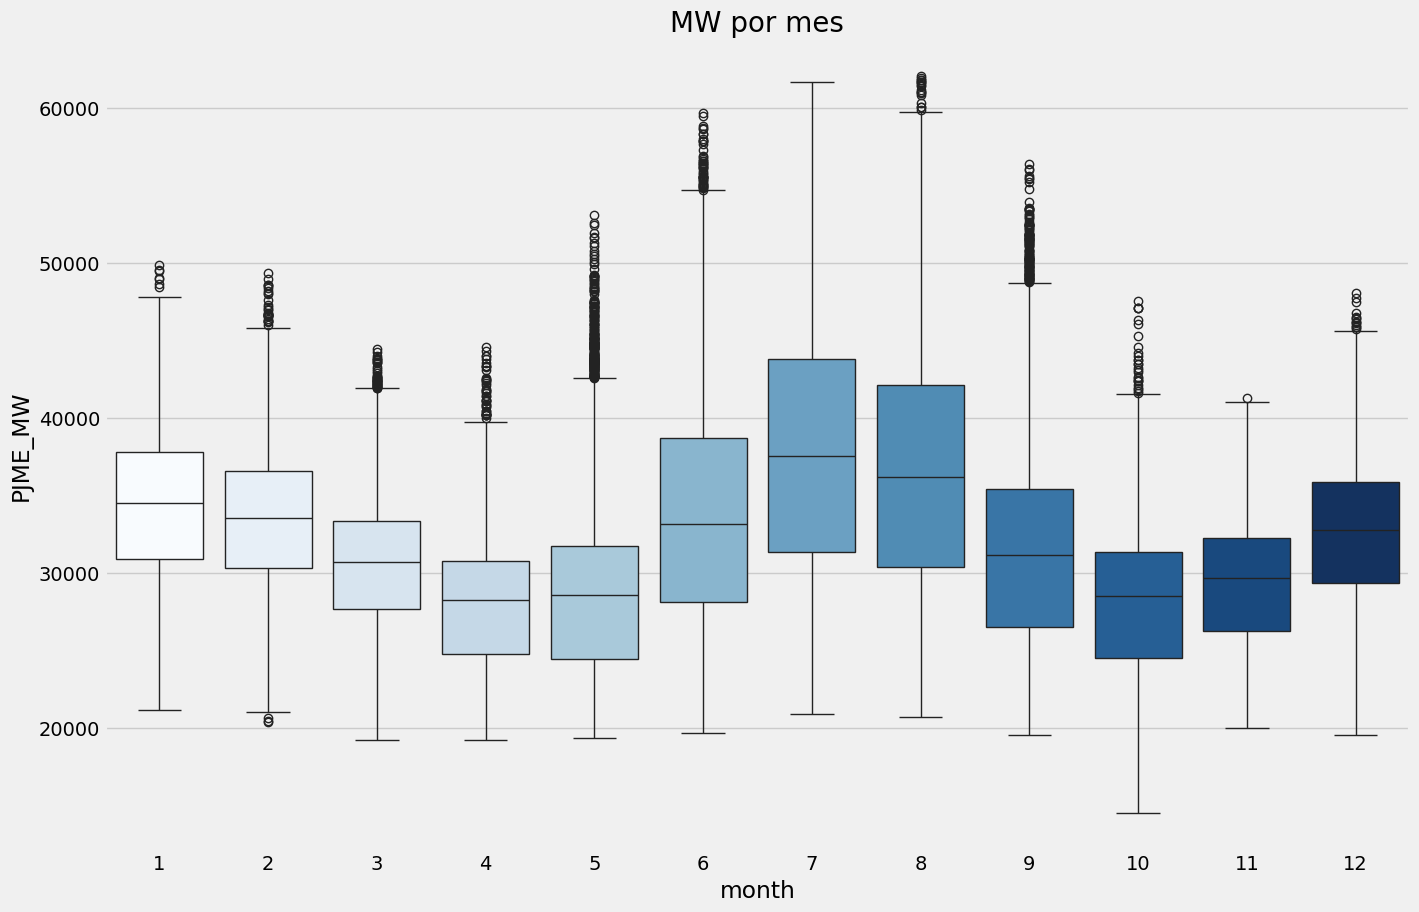

In [52]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(data=df, x='month', y='PJME_MW', hue='month',legend=False,palette='Blues')
ax.set_title("MW por mes", fontsize=20)
plt.show()

In [56]:
train_data = creacion_features(train_data)
test_data = creacion_features(test_data)

predictores = ['year', 'month', 'dayofyear', 'hour', 'dayofweek', 'quarter']
target = 'PJME_MW'

In [57]:
X_train = train_data[predictores]
y_train = train_data[target]

X_test = test_data[predictores]
y_test = test_data[target]

In [64]:
# Creacion del Modelo usando XGB

ts_model_xgb = XGBRegressor(n_estimators= 10000,
                            learning_rate=0.01,
                            early_stopping_rounds=50)

In [65]:

ts_model_xgb.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_test, y_test)],
                 verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76641
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.87768
[416]	validation_0-rmse:2804.52217	validation_1-rmse:3748.35489


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


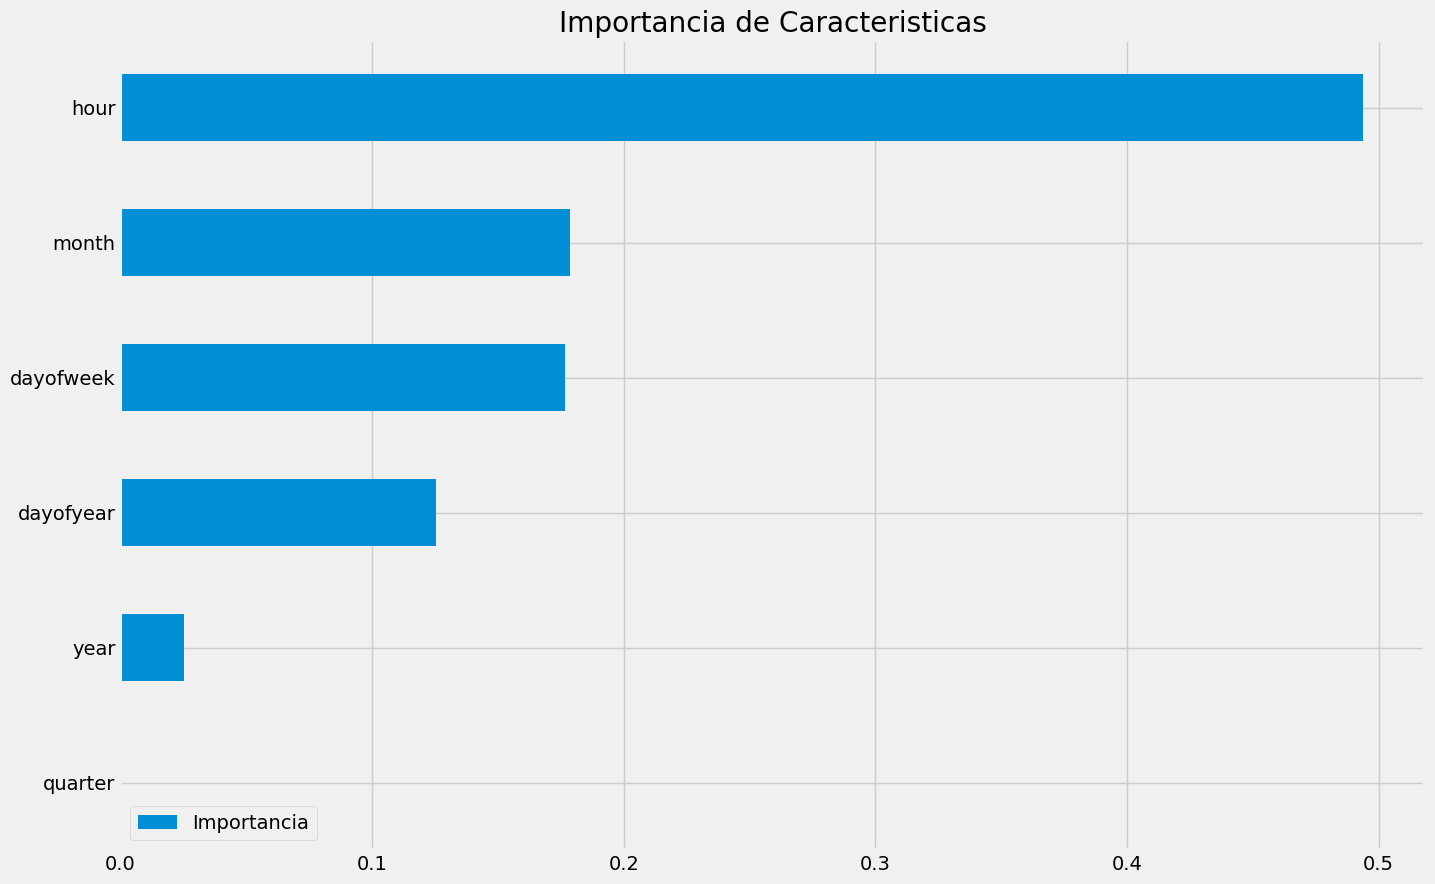

In [75]:
fig, ax = plt.subplots(figsize=(15, 10))
pd.DataFrame(data =ts_model_xgb.feature_importances_,
             index=ts_model_xgb.feature_names_in_,
             columns=['Importancia']).sort_values(by='Importancia',ascending=True).plot(ax=ax,kind='barh',
                                                                                         title='Importancia de Caracteristicas')
plt.show()

In [83]:
# Predicciones en la data de testeo
y_pred = ts_model_xgb.predict(X_test)
test_data['predicciones'] = y_pred
test_data

,PJME_MW,year,month,dayofyear,hour,dayofweek,quarter,predicciones
Datetime,,,,,,,,
2015-01-01 00:00:00,32802.0,2015,1,1,0,3,1,32393.351562
2015-12-31 01:00:00,24305.0,2015,12,365,1,3,4,29040.167969
2015-12-31 02:00:00,23156.0,2015,12,365,2,3,4,27877.017578
2015-12-31 03:00:00,22514.0,2015,12,365,3,3,4,27576.720703
2015-12-31 04:00:00,22330.0,2015,12,365,4,3,4,27576.720703
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,2018,1,1,20,0,1,38623.246094
2018-01-01 21:00:00,43751.0,2018,1,1,21,0,1,38495.484375
2018-01-01 22:00:00,42402.0,2018,1,1,22,0,1,36229.527344


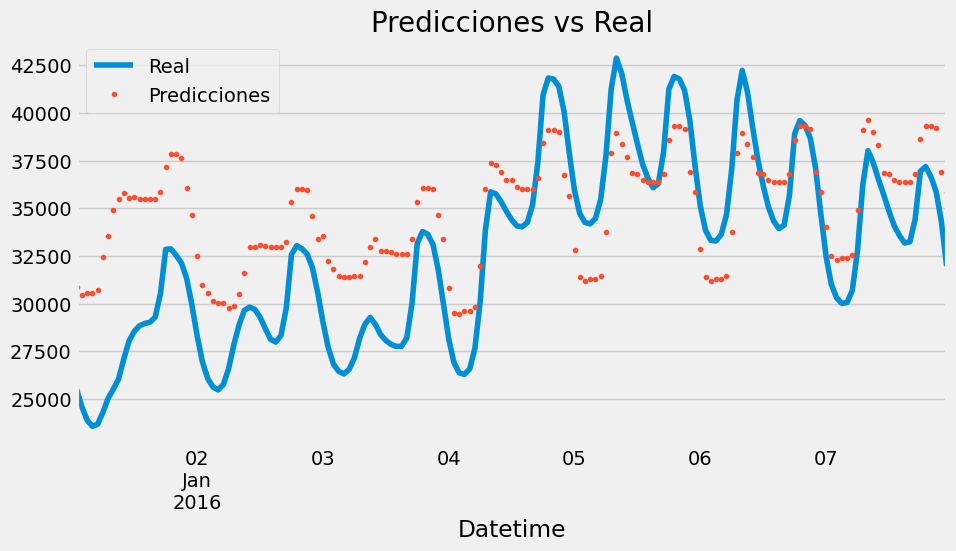

In [105]:
fig, ax = plt.subplots(figsize=(10, 5))
df.loc[(df.index > '2016-01-01') & (df.index < '2016-01-08')]['PJME_MW'].sort_index().plot(ax=ax)
test_data.loc[(test_data.index > '2016-01-01') & (test_data.index < '2016-01-08')]['predicciones'].sort_index().plot(
    ax=ax,
    style='.')
ax.set_title('Predicciones vs Real', fontsize=20)
ax.legend(['Real', 'Predicciones'])
plt.show()

In [81]:
rmse =np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 3741.0469899115005
